In [1]:
# you'll want to install torch, transformers, einops, matplotlib and scikit-learn
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import csv

In [2]:
# load model and tokenizer
# try out differ
model_name = "distilgpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [3]:
tokenizer("hey")

{'input_ids': [20342], 'attention_mask': [1]}

In [4]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [5]:
# gettin MORE names
with open('baby_names.csv') as csv_file: 
    names_reader = csv.DictReader(csv_file)
    man_names = [
        name['name'] if name['sex'] == 'boy' and int(name['year']) > 2007 else None
        for name in names_reader
    ]

with open('baby_names.csv') as csv_file: 
    names_reader = csv.DictReader(csv_file)
    woman_names = [
        name['name'] if name['sex'] == 'girl' and int(name['year']) > 2007 else None
        for name in names_reader
    ]

In [6]:
man_names = list(filter(lambda x: x is not None, man_names))
woman_names = list(filter(lambda x: x is not None, woman_names))
any([name == None for name in woman_names])

False

In [7]:
# dataset: the same sentence, but ending in a different name, for 20 masculine names and 20 feminine names
prompt_format = "Hi, my name is {}"
man_names = ['John', 'Peter', "Mark", "Paul", "Luke", "Michael", "Valmik", "Mohamed", "Cherif", "Donald", "Yang", "Ruiqi", "Collin", "Jacob", "Guillerme", "Jaime", "Ezra", "Matthew", "Kevin", "Richard"]
woman_names = ["Allie", "Emily", "Frances", "Anisha", "Jingfei", "Fei", "Michelle", "Eunice", "Yaelle", "Britney", "Sarah" , "Leah", "Angelina", "Mary", "Madeleine", "Maria", "Rebecca", "Daphne", "Christine", "Olivia"]
inp_str = [prompt_format.format(name) for name in man_names + woman_names]
labels = len(man_names) * [0] + len(woman_names) * [1]
inp_toks = tokenizer(inp_str, return_tensors="pt", padding=True, truncation=True)

In [8]:
inp_toks

{'input_ids': tensor([[17250,    11,   616,  1438,   318,  1757, 50256, 50256],
        [17250,    11,   616,  1438,   318,  5613, 50256, 50256],
        [17250,    11,   616,  1438,   318,  2940, 50256, 50256],
        [17250,    11,   616,  1438,   318,  3362, 50256, 50256],
        [17250,    11,   616,  1438,   318, 11336, 50256, 50256],
        [17250,    11,   616,  1438,   318,  3899, 50256, 50256],
        [17250,    11,   616,  1438,   318,  3254,    76,  1134],
        [17250,    11,   616,  1438,   318, 27469, 50256, 50256],
        [17250,    11,   616,  1438,   318, 19305,   361, 50256],
        [17250,    11,   616,  1438,   318,  3759, 50256, 50256],
        [17250,    11,   616,  1438,   318, 10998, 50256, 50256],
        [17250,    11,   616,  1438,   318,   371,  9019, 40603],
        [17250,    11,   616,  1438,   318,  7778,   259, 50256],
        [17250,    11,   616,  1438,   318, 12806, 50256, 50256],
        [17250,    11,   616,  1438,   318,  1962,  4665,  132

In [9]:
# apply the model to the 20+20 inputs, while saving the hidden state at each layer
out = model(**inp_toks, output_hidden_states=True)

In [10]:
out.logits.shape

torch.Size([40, 8, 50257])

In [11]:
# tensor of shape (num_sentences, num_layers, num_tokens, hidden_size)
hidden = torch.stack(out.hidden_states, dim=1)
hidden.shape

torch.Size([40, 7, 8, 768])

In [12]:
# challenge: choose a sentence, and get the 5 most likely tokens that are predicted after "Hi, my name is"
# tips: you can use out.logits and t1he `topk` function. 'Hi, my name is' is common to every sentence, so it doesn't matter which one you choose

# decoding for all the phrases 
max_indexes = out.logits.argmax(-1)
# print(max_indexes)
tokenizer.batch_decode(max_indexes)

[' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is Jeriki,',
 ' The and name is J,TheThe',
 ' The and name is Ji,The',
 ' The and name is J TrumpTheThe',
 ' The and name is J.TheThe',
 ' The and name is J.,,',
 ' The and name is Jin,The',
 ' The and name is J.TheThe',
 ' The and name is Jillamo de',
 ' The and name is J,TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is Jie,The',
 ' The and name is J.TheThe',
 ' The and name is J,TheThe',
 ' The and name is Jast.The',
 ' The and name is J.i,',
 ' The and name is J,TheThe',
 ' The and name is J.TheThe',
 ' The and name is J.-e',
 ' The and name is Jukia,',
 ' The and name is Jney,The',
 ' The and name is J.TheThe',
 ' The and name is J.TheThe',
 ' The and name is Jina,The',
 ' The and name is J.T

In [13]:
# decoding for one phrase

max_indexes = torch.topk(out.logits[:, 4, :].argmax(-1), 5)
print(max_indexes)
tokenizer.batch_decode(max_indexes.values)

torch.return_types.topk(
values=tensor([449, 449, 449, 449, 449]),
indices=tensor([0, 1, 2, 3, 4]))


[' J', ' J', ' J', ' J', ' J']

It only predicts "J" after "Hi, my name is " which is not very accurate

In [14]:
# challenge: get the same result, but instead of directly using out.logits, reconstruct it by using the final hidden state and the model's linear decoding layer model.lm_head.weight
# remember to use torch.einsum
model_outs = model.lm_head.weight
last_hidden = hidden[:, -1, :, :]
print(last_hidden.shape, model_outs.shape)
sum = torch.einsum("ptd,wd->ptw", last_hidden, model_outs) # handmade logits

print((sum == out.logits).all()) # checking it is equal to the logits

tokenizer.batch_decode(
    torch.topk(sum[:, 4, :].argmax(-1), 5).values
)

torch.Size([40, 8, 768]) torch.Size([50257, 768])
tensor(True)


[' J', ' J', ' J', ' J', ' J']

In [15]:
# challenge: using the same method as above, get the 5 most likely names that are predicted after "Hi, my name is" by intermediate layers
def k_likely_predictions(m, hidden_layers, hidden_id, k=5):
    model_outs = m.lm_head.weight
    last_hidden = hidden_layers[:, hidden_id, :, :]
    sum = torch.einsum("ptd,wd->ptw", last_hidden, model_outs) # handmade logits
    return tokenizer.batch_decode(
        torch.topk(sum[:, 4, :].argmax(-1), k).values
    )

for i in range(hidden.shape[1]):
    print(f"Top predictions for hidden layer {i+1}: {k_likely_predictions(model, hidden, i)}") 

Top predictions for hidden layer 1: [' is', ' is', ' is', ' is', ' is']
Top predictions for hidden layer 2: [' the', ' the', ' the', ' the', ' the']
Top predictions for hidden layer 3: [' a', ' a', ' a', ' a', ' a']
Top predictions for hidden layer 4: [' a', ' a', ' a', ' a', ' a']
Top predictions for hidden layer 5: [' the', ' the', ' the', ' the', ' the']
Top predictions for hidden layer 6: [' the', ' the', ' the', ' the', ' the']
Top predictions for hidden layer 7: [' J', ' J', ' J', ' J', ' J']


In [16]:
# for every sentence, get the index of the last token before padding
# this is the token whose embeddings we will study
# because some names are represented with more tokens than others, it's not the same index for every sentence
final_ids = ((inp_toks.input_ids != tokenizer.pad_token_id).sum(1) - 1).tolist()

In [17]:
# get the corresponding hidden states of the token of interest, for every sentence and every layer
last_hidden = torch.stack([hidden[i, :, final_ids[i], :] for i in range(len(final_ids))], dim=0).detach().numpy()
print(last_hidden.shape)

(40, 7, 768)


In [18]:
# focus on a single layer, and normalize the hidden states for every sentence
layer = -1 # last layer
X = last_hidden[:,layer,:]
X = (X - X.mean(axis=0)) / X.std(axis=0) # X has shape (num_sentences, hidden_size)
X.shape

(40, 768)

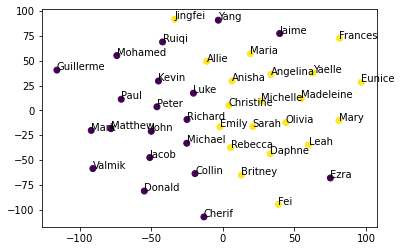

In [19]:
# to visualize, we need to use t-SNE to reduce the dimensionality of the hidden states from hidden_size to 2
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, )
for i in range(len(inp_str)):
    ax.annotate((man_names + woman_names)[i], (X_embedded[i, 0], X_embedded[i, 1]))
plt.show()

In [20]:
# logistic regression to predict gender from the hidden embeddings
train_X = np.concatenate([X[:(len(man_names) // 2)], X[(len(man_names)):(len(man_names) + len(woman_names) // 2)]])
train_Y = labels[:(len(man_names) // 2)] + labels[(len(man_names)):(len(man_names) + len(woman_names) // 2)]


test_X = np.concatenate([X[(len(man_names) // 2):(len(man_names))], X[(len(man_names) + len(woman_names) // 2):(len(man_names) + len(woman_names))]])
test_Y = labels[(len(man_names) // 2):(len(man_names))] + labels[(len(man_names) + len(woman_names) // 2):(len(man_names) + len(woman_names))]

clf = LogisticRegression().fit(train_X, train_Y)
pred_Y = clf.predict(test_X)
accuracy = 1 - np.mean(np.array(pred_Y) - np.array(test_Y))
print(accuracy)

0.75


In [21]:
# next step: do these visualizations and logistic regressions with the other layers:
# at what layer does the clustering appear?
def cluster(hidden_layer, layer):
    print(f"Clustering for layer {layer + 1}")
    X = last_hidden[:,layer,:]
    X = (X - X.mean(axis=0)) / X.std(axis=0) # X has shape (num_sentences, hidden_size)

    X_embedded = TSNE(n_components=2, init='random').fit_transform(X)
    fig, ax = plt.subplots()
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, )
    for i in range(len(inp_str)):
        ax.annotate((man_names + woman_names)[i], (X_embedded[i, 0], X_embedded[i, 1]))
    
    print(f"\tCluster")
    plt.show()

    train_X = np.concatenate([X[:(len(man_names) // 2)], X[(len(man_names)):(len(man_names) + len(woman_names) // 2)]])
    train_Y = labels[:(len(man_names) // 2)] + labels[(len(man_names)):(len(man_names) + len(woman_names) // 2)]


    test_X = np.concatenate([X[(len(man_names) // 2):(len(man_names))], X[(len(man_names) + len(woman_names) // 2):(len(man_names) + len(woman_names))]])
    test_Y = labels[(len(man_names) // 2):(len(man_names))] + labels[(len(man_names) + len(woman_names) // 2):(len(man_names) + len(woman_names))]

    clf = LogisticRegression().fit(train_X, train_Y)
    pred_Y = clf.predict(test_X)
    accuracy = 1 - np.mean(np.array(pred_Y) - np.array(test_Y))
    print(f"\tModel Accuracy {accuracy}")

Clustering for layer 1
	Cluster


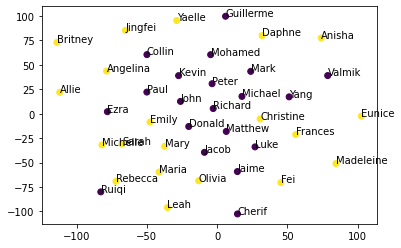

	Model Accuracy 0.8
Clustering for layer 2
	Cluster


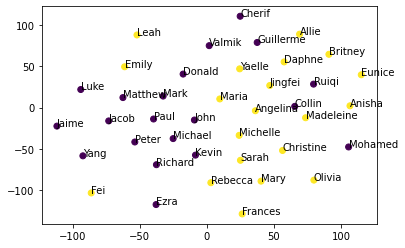

	Model Accuracy 0.75
Clustering for layer 3
	Cluster


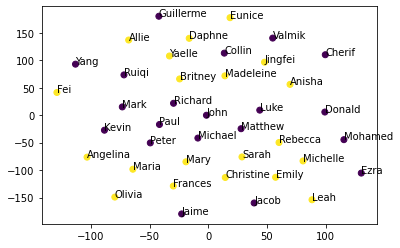

	Model Accuracy 0.75
Clustering for layer 4
	Cluster


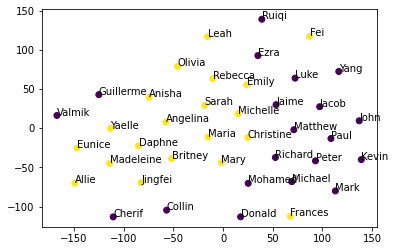

	Model Accuracy 0.8
Clustering for layer 5
	Cluster


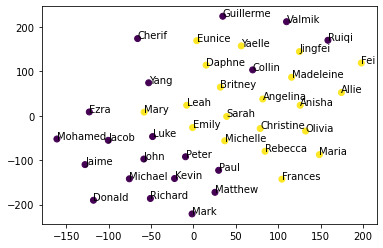

	Model Accuracy 0.75
Clustering for layer 6
	Cluster


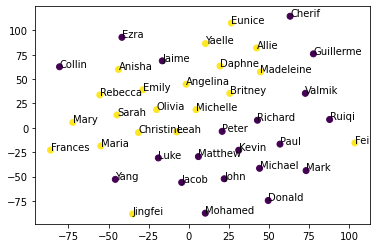

	Model Accuracy 0.75
Clustering for layer 7
	Cluster


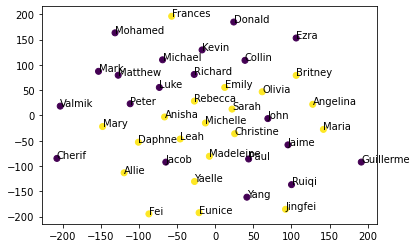

	Model Accuracy 0.75


In [22]:
for i in range(hidden.shape[1]):
    cluster(last_hidden, i)

In [23]:
# project embeddings orthogonal to the logistic regression direction 
# (TODO: check that I multiplied the matrices right)
direction = clf.coef_
dir_proj = direction.T @ direction / np.sum(direction**2)
dir_proj.shape
X_proj = X - X @ dir_proj

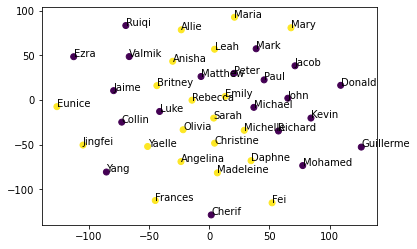

In [24]:
# use TSNE to visualize the projected embeddings: how do they cluster?
X_proj_embedded = TSNE(n_components=2, init='random').fit_transform(X_proj)
fig, ax = plt.subplots()
ax.scatter(X_proj_embedded[:, 0], X_proj_embedded[:, 1], c=labels, )
for i in range(len(inp_str)):
    ax.annotate((man_names + woman_names)[i], (X_proj_embedded[i, 0], X_proj_embedded[i, 1]))
plt.show()

In [25]:
# the clusters seem worse, but we can probably make them even worse
# one way to do this would be to iterate: run logistic regression on X_proj, project X_proj on the new direction, and repeat
# try it out!